# Оптимизация нейронных сетей. Метод обратного распространения ошибки (ноутбук)

> Узнаем как устроена оптимизация нейронных сетей. Оптимизация в `PyTorch`.

## План ноутбука

1. Высокоуровневое API для обучение нейросетей в `PyTorch`
2. Обучение первой нейросети в `PyTorch`

## Высокоуровневое API для обучение нейросетей в `PyTorch`

In [ ]:
import torch
import torch.nn as nn

### Создание объекта нейросети

In [ ]:
net = nn.Sequential(
    nn.Linear(700, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

In [ ]:
net

Sequential(
  (0): Linear(in_features=700, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
net[1]

ReLU()

In [ ]:
input = torch.randn((5, 700))

In [ ]:
net(input)

tensor([[-0.0938, -0.0568, -0.1576,  0.0087, -0.2977, -0.2481, -0.0068,  0.0638,
         -0.0582, -0.0262],
        [-0.0931,  0.1032, -0.0242,  0.0127, -0.1057, -0.2292, -0.2943,  0.1069,
         -0.0449,  0.0918],
        [-0.1680,  0.0783, -0.1161, -0.0587, -0.2028, -0.1454, -0.0841,  0.0949,
         -0.1775, -0.0398],
        [-0.0042, -0.0285,  0.1085, -0.0053, -0.2726, -0.0395, -0.0897,  0.1075,
         -0.0222,  0.0654],
        [-0.1073,  0.0336, -0.0768, -0.0426, -0.2118, -0.0780, -0.1497,  0.1055,
          0.0659, -0.0997]], grad_fn=<AddmmBackward0>)

In [ ]:
from collections import OrderedDict

net = nn.Sequential(
    OrderedDict(
        [
            ('linear1', nn.Linear(700, 500)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(500, 200)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(200, 10))
        ]
    )
)

In [ ]:
net.linear1.weight

Parameter containing:
tensor([[-0.0229,  0.0310,  0.0207,  ..., -0.0005, -0.0017, -0.0201],
        [ 0.0202,  0.0189, -0.0334,  ...,  0.0069,  0.0178,  0.0312],
        [-0.0316,  0.0196, -0.0033,  ..., -0.0069, -0.0150,  0.0334],
        ...,
        [ 0.0133, -0.0092, -0.0096,  ..., -0.0293,  0.0145,  0.0084],
        [-0.0307, -0.0108,  0.0119,  ..., -0.0339,  0.0199, -0.0335],
        [-0.0085,  0.0221,  0.0102,  ...,  0.0079, -0.0174,  0.0203]],
       requires_grad=True)

In [ ]:
net

Sequential(
  (linear1): Linear(in_features=700, out_features=500, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
input_tensor = torch.rand(10, 700)

net(input_tensor).shape

torch.Size([10, 10])

In [ ]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(700, 500)
        self.linear2 = nn.Linear(500, 200)
        self.linear3 = nn.Linear(200, 10)

        self.activation1 = nn.ReLU()
        self.activation2 = nn.Sigmoid()

    def forward(self, x):
        output = self.activation1(self.linear1(x))
        output = self.activation2(self.linear2(output))
        output = self.linear3(output)

        return output

In [ ]:
net = CustomTaskNetwork()

net(input_tensor).shape

torch.Size([10, 10])

In [ ]:
net = net.to("cuda:0")

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

452710

In [ ]:
net.train()

net.eval()

net.requires_grad_(False)

CustomTaskNetwork(
  (linear1): Linear(in_features=700, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
  (activation): ReLU()
)

In [ ]:
n = next(net.parameters())
n

Parameter containing:
tensor([[ 0.0134,  0.0136,  0.0165,  ...,  0.0072,  0.0363, -0.0219],
        [-0.0316,  0.0150,  0.0314,  ..., -0.0340, -0.0120,  0.0206],
        [ 0.0206, -0.0036, -0.0176,  ..., -0.0174, -0.0063,  0.0301],
        ...,
        [-0.0020, -0.0284, -0.0108,  ..., -0.0317,  0.0217, -0.0087],
        [-0.0010, -0.0159, -0.0206,  ...,  0.0199,  0.0308, -0.0178],
        [-0.0039,  0.0278,  0.0376,  ...,  0.0324, -0.0034,  0.0348]],
       device='cuda:0')

In [ ]:
type(n)

torch.nn.parameter.Parameter

In [ ]:
torch.save(net.state_dict(), "weights.pth")

In [ ]:
weights = torch.load("weights.pth")
net.to("cuda:0")
net.load_state_dict(weights)
net.state_dict()

<ipython-input-189-89f325a46c96>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("weights.pth")


OrderedDict([('linear1.weight',
              tensor([[ 0.0134,  0.0136,  0.0165,  ...,  0.0072,  0.0363, -0.0219],
                      [-0.0316,  0.0150,  0.0314,  ..., -0.0340, -0.0120,  0.0206],
                      [ 0.0206, -0.0036, -0.0176,  ..., -0.0174, -0.0063,  0.0301],
                      ...,
                      [-0.0020, -0.0284, -0.0108,  ..., -0.0317,  0.0217, -0.0087],
                      [-0.0010, -0.0159, -0.0206,  ...,  0.0199,  0.0308, -0.0178],
                      [-0.0039,  0.0278,  0.0376,  ...,  0.0324, -0.0034,  0.0348]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([-3.3437e-02,  8.8278e-03, -2.7222e-02, -1.3798e-02, -9.9189e-03,
                      -1.2100e-02,  2.0397e-02, -2.5868e-02, -1.5224e-02, -2.9784e-02,
                      -2.8520e-02,  3.4915e-02, -7.3473e-03,  3.6728e-02,  1.0276e-02,
                      -2.9704e-02, -1.2123e-03, -2.3111e-02, -2.7641e-02, -1.9581e-02,
                  

Если мы хотим проинициализировать сетку какими-то весами из словаря, то важно чтобы названия и размеры параметров в передаваемом словаре совпадали с названиями и размерами параметров сетки

In [ ]:
net.load_state_dict({'linear5.weight': torch.rand((1, 2, 3))})

RuntimeError: Error(s) in loading state_dict for CustomTaskNetwork:
	Missing key(s) in state_dict: "linear1.weight", "linear1.bias", "linear2.weight", "linear2.bias", "linear3.weight", "linear3.bias". 
	Unexpected key(s) in state_dict: "linear5.weight". 

### Оптимизаторы

In [ ]:
from torch import optim

In [ ]:
optim.SGD, optim.AdamW

(torch.optim.sgd.SGD, torch.optim.adamw.AdamW)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
optimizer = optim.SGD(
    [
        {'params': net.linear1.parameters()},
        {'params': net.linear2.parameters(), 'lr': 1e-3}
    ],
    lr=1e-2,
    momentum=0.9
)

In [ ]:
optimizer.step()

In [ ]:
optimizer.zero_grad()

In [ ]:
checkpoint = {
    'epoch': 23,
    'model': net,
    'optimizer': optimizer
    }
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
checkpoint = torch.load('checkpoint.pth')
epoch = checkpoint['epoch']
model = checkpoint['model']
optimizer = checkpoint['optimizer']

<ipython-input-200-93a2b2a75bfe>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


In [ ]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

### Функции потерь

In [ ]:
nn.L1Loss, nn.MSELoss, nn.CrossEntropyLoss

(torch.nn.modules.loss.L1Loss,
 torch.nn.modules.loss.MSELoss,
 torch.nn.modules.loss.CrossEntropyLoss)

In [ ]:
loss = nn.MSELoss()

In [ ]:
input_tensor = torch.randn(10, 700).to("cuda")
net = net.to("cuda")
input = net(input_tensor)
target = torch.randn(10, 10).to("cuda")

output = loss(input, target)

print(output)

output.backward()

tensor(1.0119, device='cuda:0', grad_fn=<MseLossBackward0>)


In [ ]:
net.linear1.weight.grad

tensor([[-9.2332e-04,  2.6007e-03, -1.8904e-03,  ...,  1.6872e-03,
          1.6887e-05,  2.0860e-03],
        [-1.6819e-03,  1.0880e-03,  8.3644e-04,  ...,  2.3654e-03,
         -3.0514e-04, -1.3008e-03],
        [ 7.5575e-04, -7.8337e-04,  1.1336e-03,  ...,  9.3583e-04,
          1.2389e-03,  1.9590e-03],
        ...,
        [ 3.3582e-04, -2.7879e-05, -2.0966e-03,  ..., -2.7049e-03,
          1.1234e-03,  9.5465e-04],
        [ 1.2336e-04, -9.6323e-04, -1.4859e-03,  ...,  3.1364e-04,
          6.3375e-04, -5.9114e-04],
        [ 2.2465e-03, -5.3136e-03, -1.0435e-03,  ..., -1.8979e-03,
          1.4034e-03, -5.3175e-03]], device='cuda:0')

### Датасеты и даталоадеры

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

In [ ]:
n_features = 2
n_objects = 300

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
w_true = torch.randn(n_features)

X = (torch.rand(n_objects, n_features) - 0.5) * 10
X *= (torch.arange(n_features) * 2 + 1)
Y = (X @ w_true + torch.randn(n_objects)).unsqueeze(1)

In [ ]:
X.shape, Y.shape

(torch.Size([300, 2]), torch.Size([300, 1]))

In [ ]:
dataset = TensorDataset(X, Y)

In [ ]:
dataset[7]

(tensor([-2.3342,  3.8235]), tensor([0.3727]))

In [ ]:
X[7], Y[7]

(tensor([-2.3342,  3.8235]), tensor([0.3727]))

In [ ]:
# надо отнаследоваться от Dataset и определить методы __init__, __len__ и __getitem__

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        return self.X[item], self.Y[item], "123"

In [ ]:
dataset = CustomDataset(X, Y)

In [ ]:
dataset[7]

(tensor([-2.3342,  3.8235]), tensor([0.3727]), '123')

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Lambda

dataset = MNIST("./mnist_example", transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]), download=True)

In [ ]:
dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
dataset[0][0].shape

torch.Size([784])

In [ ]:
28 * 28

784

### Общая структура обучения модели

Модель

In [ ]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, hidden_size=100):
        super().__init__()

        self.linear1 = nn.Linear(784, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 10)


    def forward(self, x):
        # (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)
        # (batch_size, 784)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

model = MLP().to("cuda")

Оптимизатор

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

Данные

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_set = MNIST('./MNIST', transform=ToTensor(), train=True, download=True)
val_set = MNIST('./MNIST', transform=ToTensor(), train=False, download=True)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, drop_last=True)

In [ ]:
count_parameters(model)

79510

In [ ]:
def test(model, loader):
    model.eval()

    correct, total = 0, 0

    for batch in loader:
        images, labels = batch[0], batch[1]
        images = images.to('cuda')
        # batch size * 1
        labels = labels.to('cuda')

        with torch.no_grad():
            # batch_size * 10
            out = model(images)
        # shape pred = batch_size * 1
        pred = torch.argmax(out, dim=1)

        total += len(pred)
        correct += (pred == labels).cpu().numpy().sum()

    return correct / total

In [ ]:
def train(model, train_loader, val_loader, optimizer, epochs=10):
    train_acc, val_acc = [], []
    model.train()

    for epoch in range(epochs):

        correct, total = 0, 0

        for images, labels in train_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()
            out = model(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(out, dim=1)

            total += len(pred)
            correct += (pred == labels).detach().cpu().numpy().sum()

        train_acc.append(correct / total)
        val_acc.append(test(model, val_loader))
        torch.save(model.state_dict(), f"my_model_{epoch}.pth")

        print(f"Epoch: {epoch}")
        print(f"train accuracy: {train_acc[-1]}")
        print(f"val accuracy: {val_acc[-1]}")

    return train_acc, val_acc

In [ ]:
test(model, train_loader)

0.10530181623931624

In [ ]:
train_acc, val_acc = train(model, train_loader, val_loader, optimizer, epochs=10)

Epoch: 0
train accuracy: 0.9124265491452992
val accuracy: 0.9549278846153846
Epoch: 1
train accuracy: 0.9647769764957265
val accuracy: 0.9674479166666666
Epoch: 2
train accuracy: 0.9749766292735043
val accuracy: 0.9712540064102564
Epoch: 3
train accuracy: 0.9792334401709402
val accuracy: 0.9736578525641025
Epoch: 4
train accuracy: 0.9834902510683761
val accuracy: 0.9712540064102564
Epoch: 5
train accuracy: 0.9857104700854701
val accuracy: 0.9730568910256411
Epoch: 6
train accuracy: 0.9879974626068376
val accuracy: 0.9766626602564102
Epoch: 7
train accuracy: 0.9911191239316239
val accuracy: 0.9764623397435898
Epoch: 8
train accuracy: 0.9919704861111112
val accuracy: 0.9778645833333334
Epoch: 9
train accuracy: 0.9936231303418803
val accuracy: 0.9772636217948718


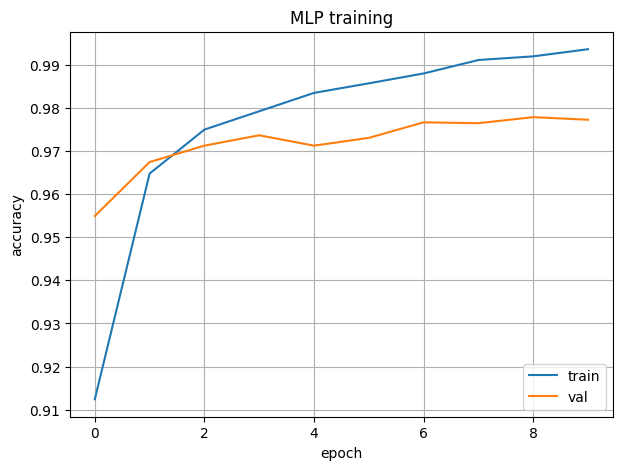

In [ ]:
import numpy as nps

plt.figure(figsize=(7, 5))

plt.plot(np.arange(10), train_acc, label='train')
plt.plot(np.arange(10), val_acc, label='val')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("MLP training")
plt.show()

Сохранение обученной модели

In [ ]:
torch.save(model.state_dict(), "my_model.pth")

Применение обученной модели для получения предсказания

In [ ]:
model.eval()

it = iter(val_loader)
elem = next(it)

with torch.no_grad():
    print(torch.argmax(model(elem[0][52].to("cuda"))))

tensor(5, device='cuda:0')


In [ ]:
dataset = MNIST("./MNIST", train=False)
dataset[52][0]

и правда

### Код из прошлого года, для самостоятельного разбора

## Обучение первой нейросети в `PyTorch`

In [ ]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

loss_fn = nn.MSELoss()

dataset = TensorDataset(X, Y)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

w_list = torch.empty(len(loader) + 1, n_features)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
net.train()
loss_progress = []

for i, (x, y) in enumerate(loader):
    w_list[i] = net.linear.weight.detach().clone()

    optimizer.zero_grad()

    output = net(x)

    loss = loss_fn(output, y)

    print(f'MSE на шаге {i} {loss.item():.5f}')

    loss.backward()

    optimizer.step()
    loss_progress.append(loss.item())

w_list[len(loader)] = net.linear.weight.detach().clone()

MSE на шаге 0 8.64131
MSE на шаге 1 4.03466
MSE на шаге 2 5.20996
MSE на шаге 3 5.75837
MSE на шаге 4 1.49795
MSE на шаге 5 2.35134
MSE на шаге 6 1.58089
MSE на шаге 7 0.73461
MSE на шаге 8 1.09013
MSE на шаге 9 6.89557
MSE на шаге 10 1.10971
MSE на шаге 11 0.32722
MSE на шаге 12 0.27246
MSE на шаге 13 1.93805
MSE на шаге 14 0.29190
MSE на шаге 15 1.05693
MSE на шаге 16 1.33455
MSE на шаге 17 1.23136
MSE на шаге 18 1.54902
MSE на шаге 19 0.55305
MSE на шаге 20 2.40002
MSE на шаге 21 0.70228
MSE на шаге 22 1.55018
MSE на шаге 23 1.61667
MSE на шаге 24 1.07051
MSE на шаге 25 2.19392
MSE на шаге 26 0.34105
MSE на шаге 27 2.05049
MSE на шаге 28 0.92615
MSE на шаге 29 1.78039
MSE на шаге 30 0.57891
MSE на шаге 31 0.75284
MSE на шаге 32 3.44392
MSE на шаге 33 1.08530
MSE на шаге 34 1.33492
MSE на шаге 35 1.61681
MSE на шаге 36 1.06016
MSE на шаге 37 0.33091
MSE на шаге 38 0.25146
MSE на шаге 39 2.74440
MSE на шаге 40 1.02553
MSE на шаге 41 0.48442
MSE на шаге 42 0.39876
MSE на шаге 43 1.3442

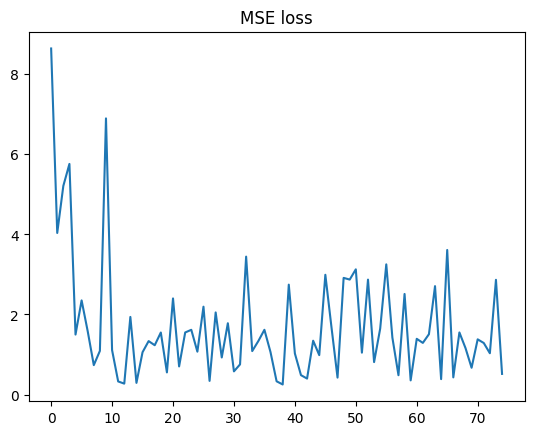

In [ ]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.show()

In [ ]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)

ModuleNotFoundError: No module named 'plot_trajectory'

А вот что будет, если забудете сделать optimizer.zero_grad()

In [ ]:
net = CustomTaskNetwork()
optimizer = optim.Adam(net.parameters(), lr=1e-1)
loss_fn = nn.MSELoss()
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
w_list = torch.empty(len(loader) + 1, n_features)

net.train()
loss_progress = []

for i, (x, y) in enumerate(loader):
    w_list[i] = net.linear.weight.detach().clone()

    if i % 4 == 0:
      optimizer.zero_grad()

    output = net(x)

    loss = loss_fn(output, y)

    print(f'MSE на шаге {i} {loss.item():.5f}')

    loss.backward()

    if i % 4 == 0:
      optimizer.step()
    loss_progress.append(loss.item())

w_list[len(loader)] = net.linear.weight.detach().clone()

MSE на шаге 0 6.64136
MSE на шаге 1 6.32261
MSE на шаге 2 4.81098
MSE на шаге 3 2.65582
MSE на шаге 4 5.01655
MSE на шаге 5 2.49205
MSE на шаге 6 0.55801
MSE на шаге 7 0.89445
MSE на шаге 8 5.16141
MSE на шаге 9 6.55043
MSE на шаге 10 4.50841
MSE на шаге 11 7.17688
MSE на шаге 12 5.68755
MSE на шаге 13 1.02357
MSE на шаге 14 4.12161
MSE на шаге 15 1.86803
MSE на шаге 16 11.72225
MSE на шаге 17 16.07097
MSE на шаге 18 54.77718
MSE на шаге 19 48.88470
MSE на шаге 20 9.92812
MSE на шаге 21 26.46951
MSE на шаге 22 21.79064
MSE на шаге 23 83.94159
MSE на шаге 24 23.48804
MSE на шаге 25 13.53572
MSE на шаге 26 69.68819
MSE на шаге 27 16.66347
MSE на шаге 28 12.04454
MSE на шаге 29 1.21379
MSE на шаге 30 17.71037
MSE на шаге 31 2.63841
MSE на шаге 32 9.35547
MSE на шаге 33 27.83498
MSE на шаге 34 15.75448
MSE на шаге 35 25.87412
MSE на шаге 36 21.04153
MSE на шаге 37 13.39895
MSE на шаге 38 88.76398
MSE на шаге 39 42.34043
MSE на шаге 40 145.78154
MSE на шаге 41 127.93519
MSE на шаге 42 190.3

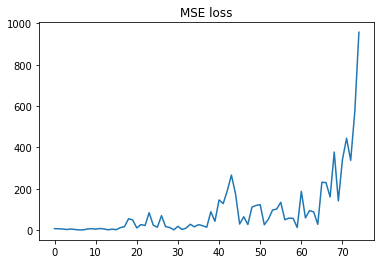

In [ ]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.show()

In [ ]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)

Теперь обучим сеть в несколько эпох

In [ ]:
num_epochs = 5

w_list = torch.empty(len(loader) * num_epochs + 1, n_features)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

In [ ]:
net.train()

loss_progress = []

for epoch in range(num_epochs):
    total_loss = 0

    for i, (x, y) in enumerate(loader):
        w_list[i + epoch * len(loader)] = net.linear.weight.detach().clone()

        optimizer.zero_grad()

        output = net(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        loss_progress.append(loss.item())

        loss.backward()

        optimizer.step()

    total_loss /= len(loader)

    print(f'MSE после эпохи {epoch} {total_loss:.5f}')

w_list[len(loader) * num_epochs] = net.linear.weight.detach().clone()

MSE после эпохи 0 4.36653
MSE после эпохи 1 1.21639
MSE после эпохи 2 1.25964
MSE после эпохи 3 1.34328
MSE после эпохи 4 1.34536


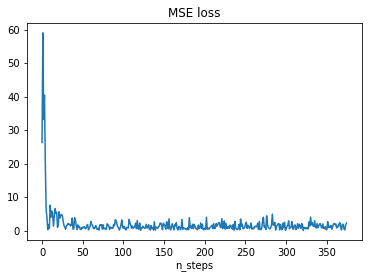

In [ ]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.xlabel("n_steps")
plt.show()

In [ ]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)